In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [5]:
img1_dir = "../../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

gpu_device = 0

num_folds = 15

num_classes = 3

num_workers_te = 0
batch_size_te = 1

num_slices = 48
size_x = 320
size_y = 320

max_epochs = 500
net_channels=(32, 64, 64)
net_strides=(2, 2)

model_filename_base = "./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold"

num_images = len(all_images)
print(num_images)

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


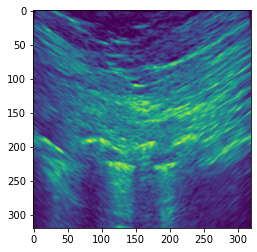

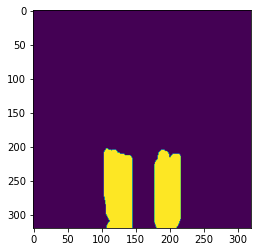

In [6]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [7]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ARGUS_RandSpatialCropSlicesd(num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [8]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

torch.Size([1, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


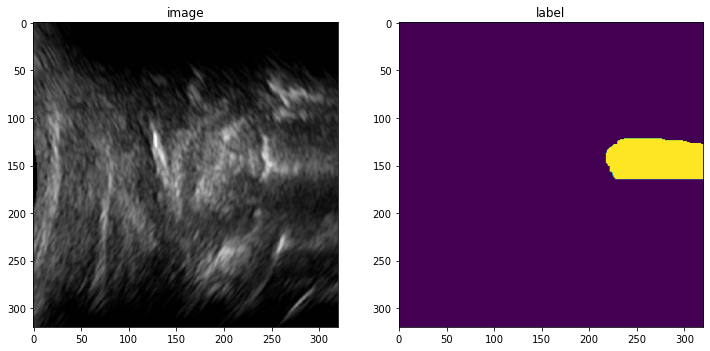

tensor(0.) tensor(1.)


In [9]:
imgnum = 0
check_data = first(test_loader[0])
image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()
print(label.min(), label.max())

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:"+str(gpu_device))

In [11]:
def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds)

    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        
        metric_file = model_filename_base+"_val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        plt.figure("train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Epoch Average Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.subplot(1, 2, 2)
        plt.title("Val Mean Dice")
        x = [2 * (i + 1) for i in range(len(metric_values))]
        y = metric_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.show()
    else:
        print("  File not found:", loss_file)
    
    model_file = model_filename_base+'_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            for b,test_data in enumerate(test_loader):
                roi_size = (size_x, size_y, num_slices)
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    print(test_files[vfold_num][i]["image"])
                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = test_data["image"][j, 0, :, :, 8]
                    plt.imshow(tmpV, cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    tmpV = test_data["label"][j, 0, :, :, 8]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    plt.imshow(tmpV)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    (maxZ, maxZI) = torch.max(test_outputs, dim=4)
                    mC = np.zeros([maxZ.shape[2],maxZ.shape[3]])
                    for y in range(maxZ.shape[2]):
                        for x in range(maxZ.shape[3]):
                            m1 = 0
                            m2 = 0
                            m1C = 0
                            for c in range(num_classes):
                                if maxZ[j,c,y,x] > m2:
                                    m2 = maxZ[j,c,y,x]
                                if maxZ[j,c,y,x] > m1:
                                    m2 = m1
                                    m1 = maxZ[j,c,y,x]
                                    m1C = c
                            if m1>0.95 and m1-m2>0.4:
                                mC[y,x] = m1C
                    #tmpV = torch.argmax(maxV, dim=1).detach().cpu()[j,:,:]
                    #tmpV = torch.argmax(test_outputs, dim=1).detach().cpu()[j, :, :, 8]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    mC[0,0]=1
                    mC[0,1]=2
                    mC[0,2]=3
                    plt.imshow(mC)
                    #plt.imshow(tmpV)
                    plt.show()
                    for c in range(num_classes):
                        arrimg = test_outputs.detach().cpu()[j,c,:,:,:]
                        itkimg = itk.GetImageFromArray(arrimg)
                        filename = model_filename_base+"_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".mha"
                        itk.imwrite(itkimg, filename)

                    i += 1
    else:
        print("  File not found:", model_file)


VFOLD = 0 of 15


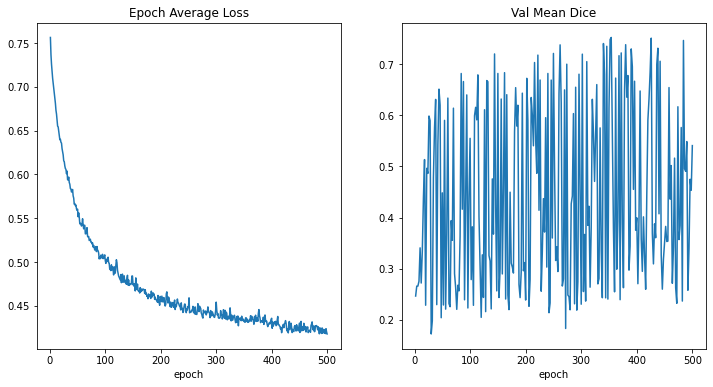

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/247ns_image_2734882394424_CLEAN.nii.gz


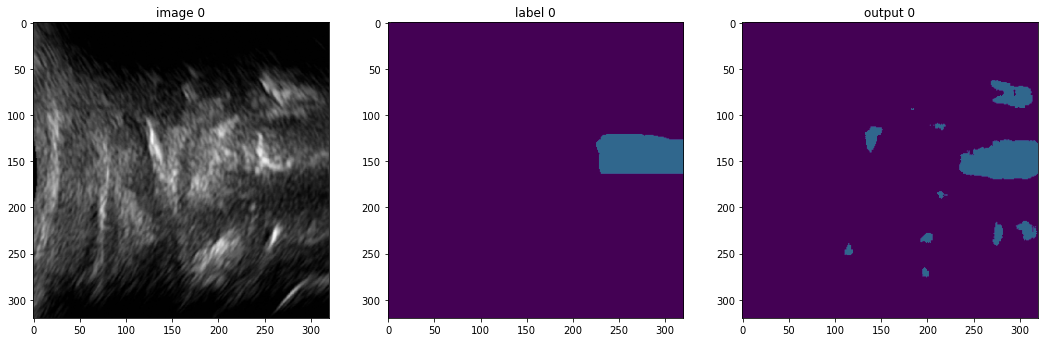

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/247ns_image_2743083265515_CLEAN.nii.gz


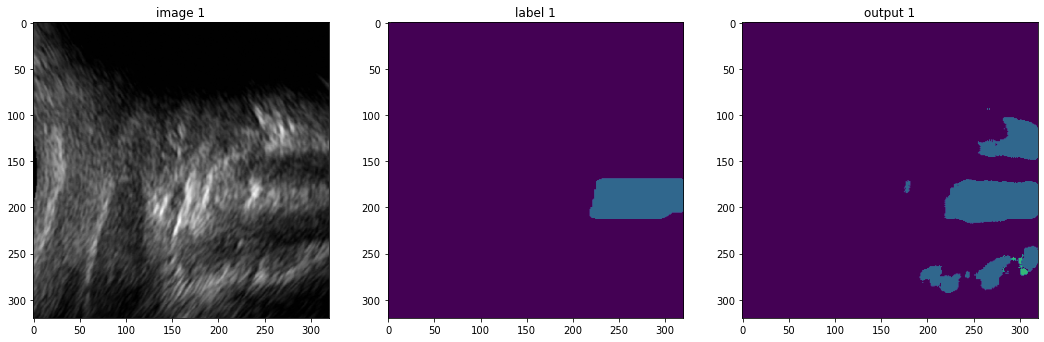

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/236s_iimage_1139765223418_CLEAN.nii.gz


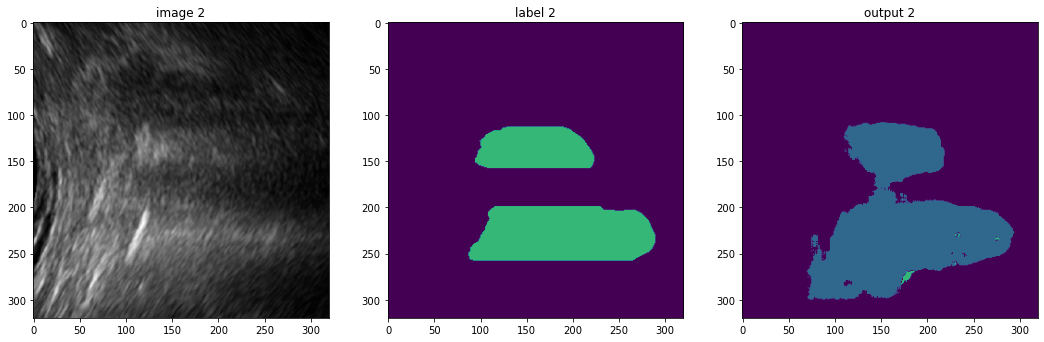

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/236s_iimage_1327616672148_clean.nii.gz


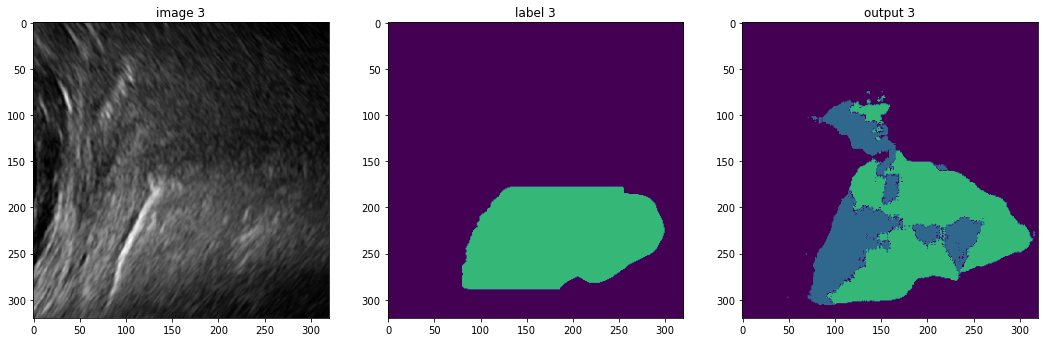

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/237s_iimage_24164968068436_CLEAN.nii.gz


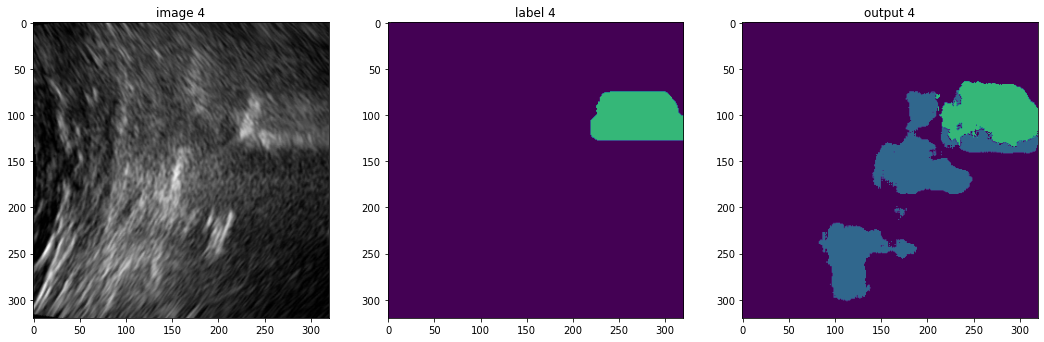

VFOLD = 1 of 15


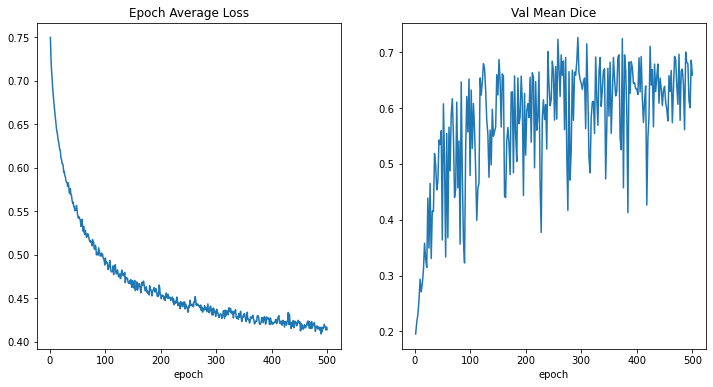

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_Image_262499828648_clean.nii.gz


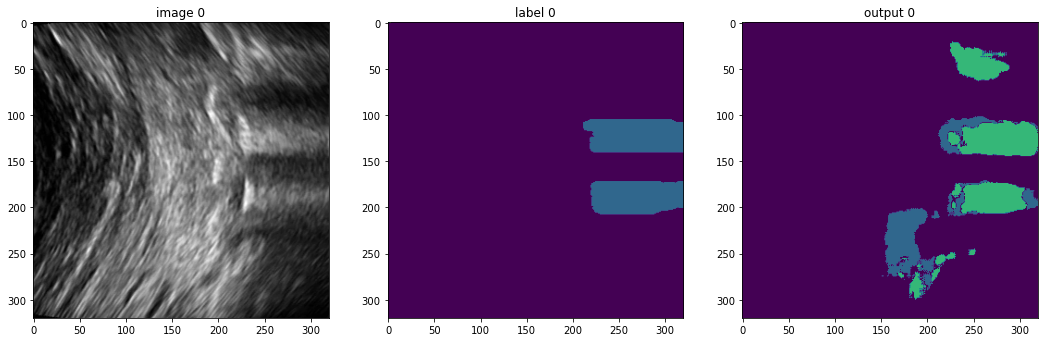

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz


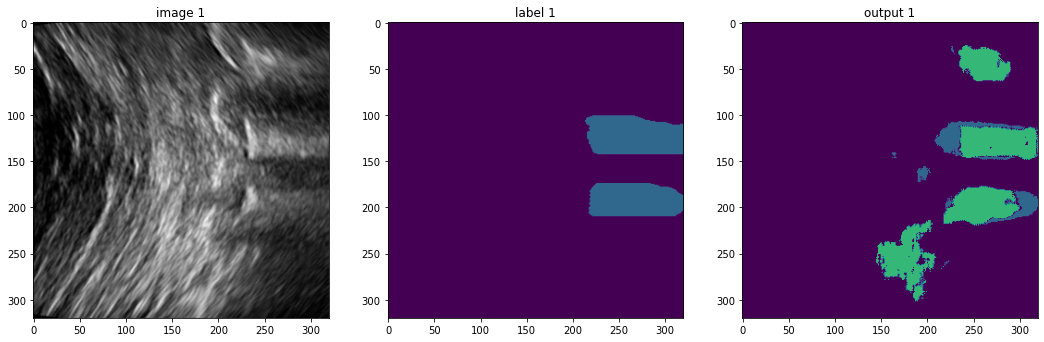

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/004s_iimage_73815992352100_clean.nii.gz


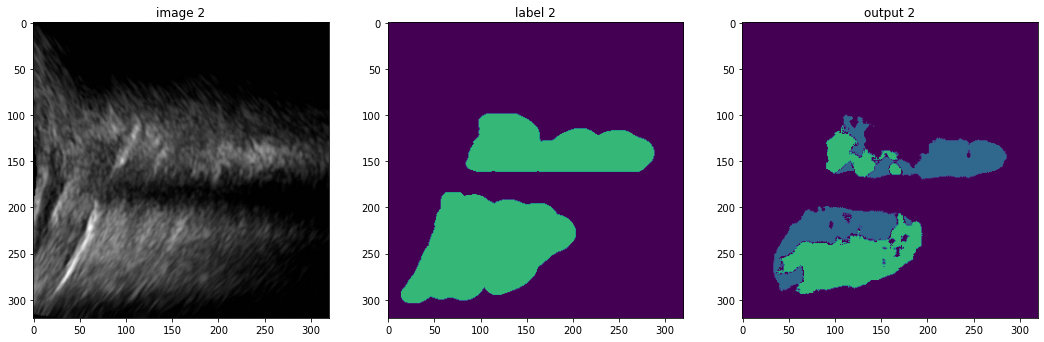

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/004s_iimage_74132233134844_clean.nii.gz


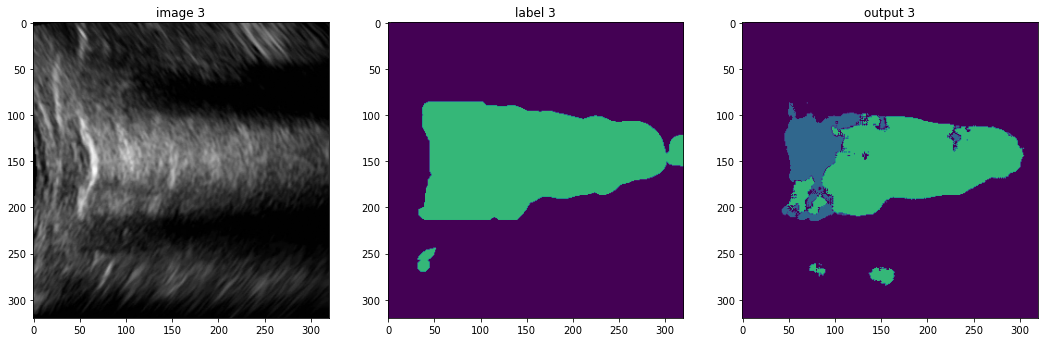

VFOLD = 2 of 15


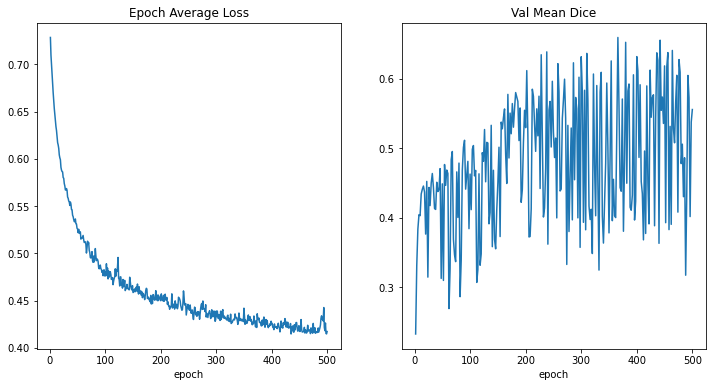

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.nii.gz


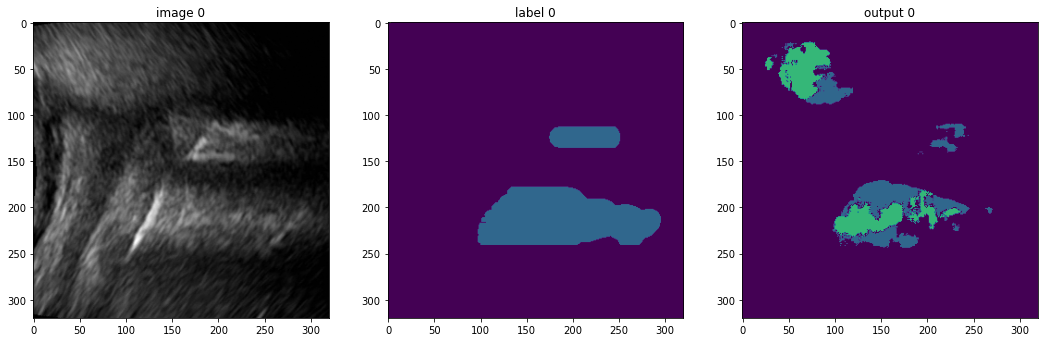

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1087766719219_clean.nii.gz


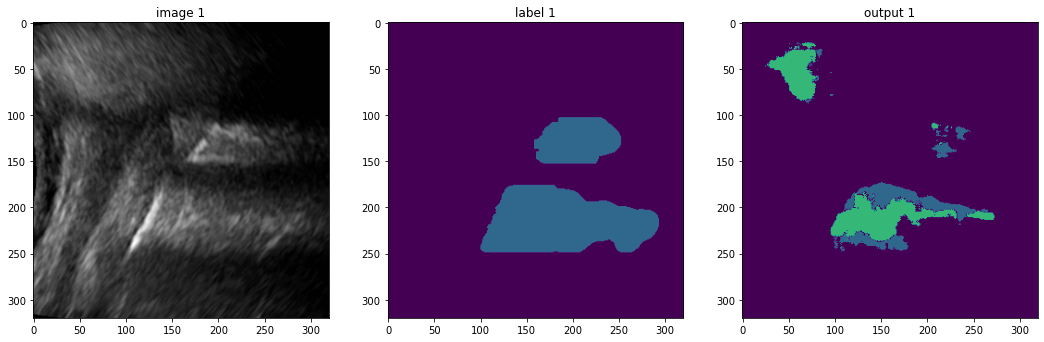

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/019s_iimage_10705997566592_CLEAN.nii.gz


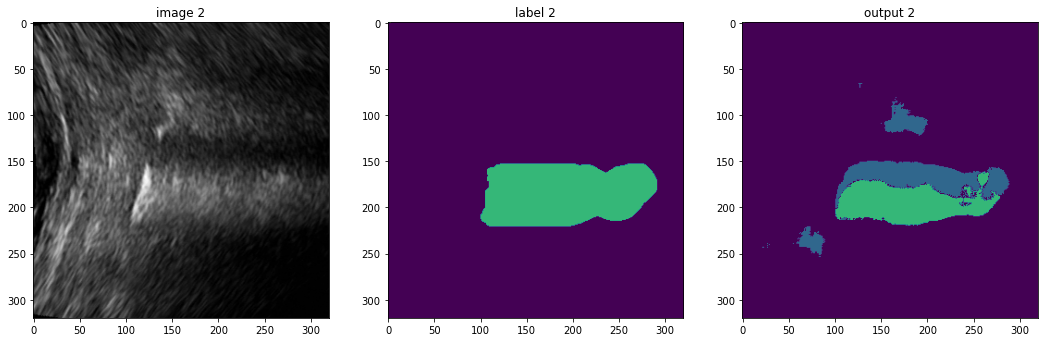

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/019s_iimage_10891015221417_clean.nii.gz


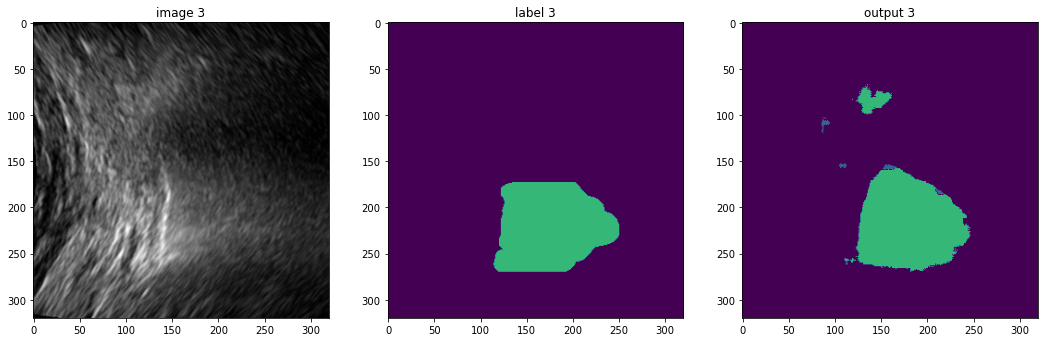

VFOLD = 3 of 15


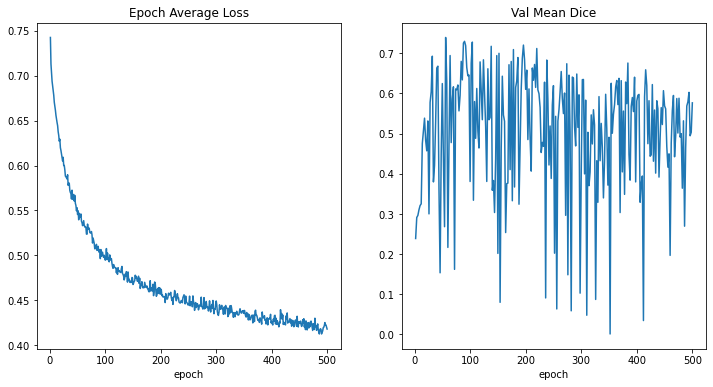

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/027ns_image_4641643404894_CLEAN.nii.gz


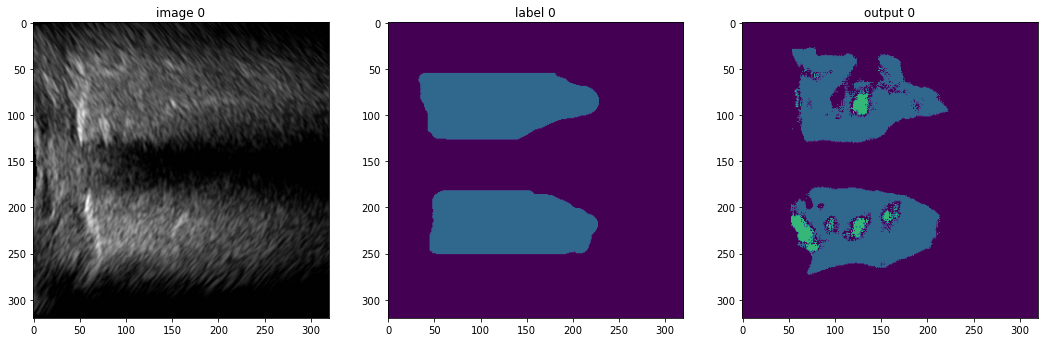

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/027ns_image_4743880599022_clean.nii.gz


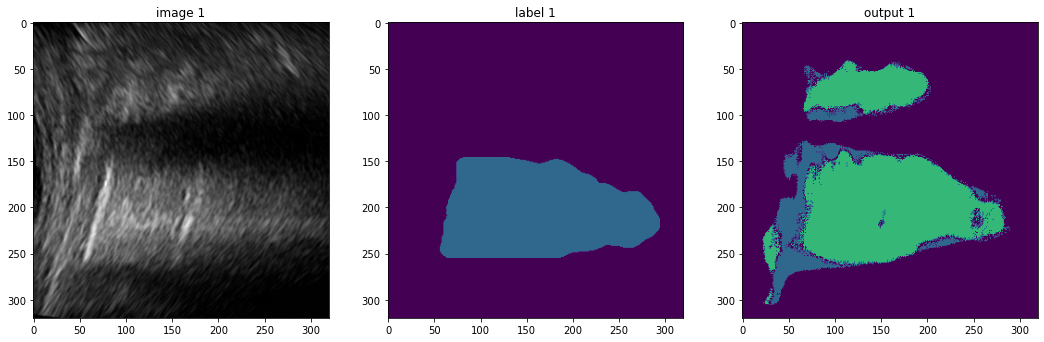

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/030s_iimage_1180496934444_clean.nii.gz


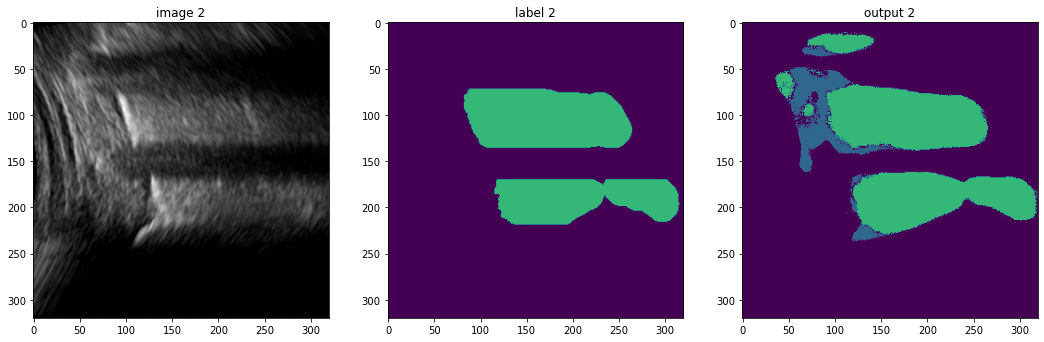

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/030s_iimage_677741729740_clean.nii.gz


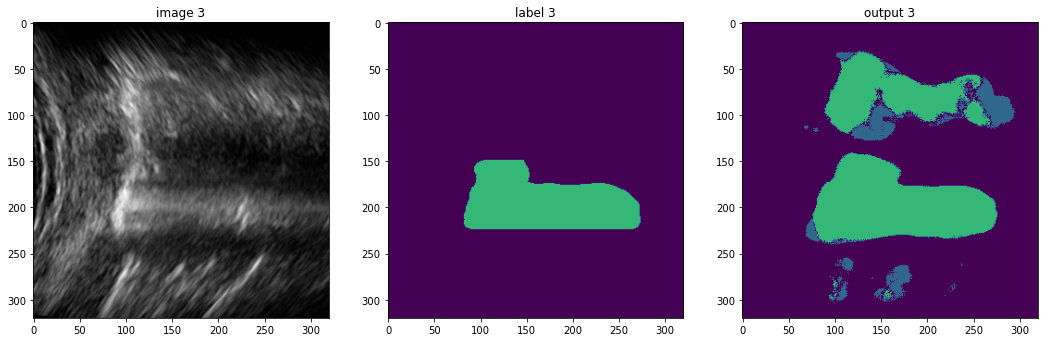

VFOLD = 4 of 15


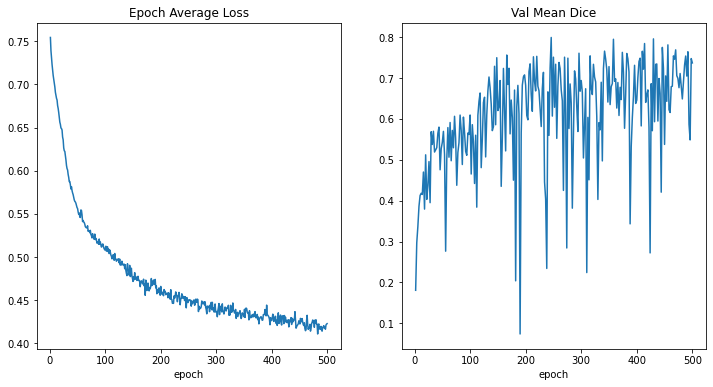

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/035ns_image_1394469579519_clean.nii.gz


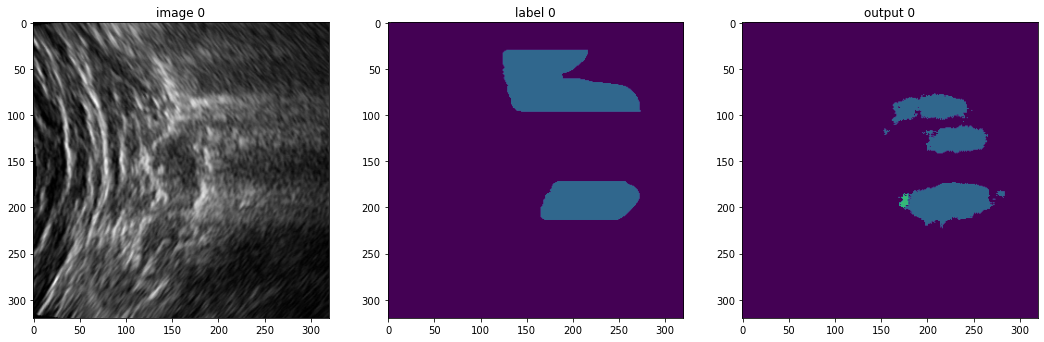

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/035ns_image_1404802450036_clean.nii.gz


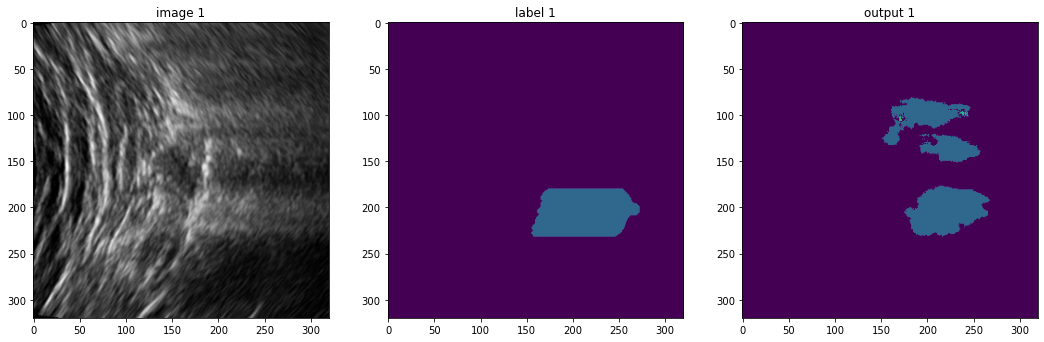

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/034s_iimage_3368391807672_clean.nii.gz


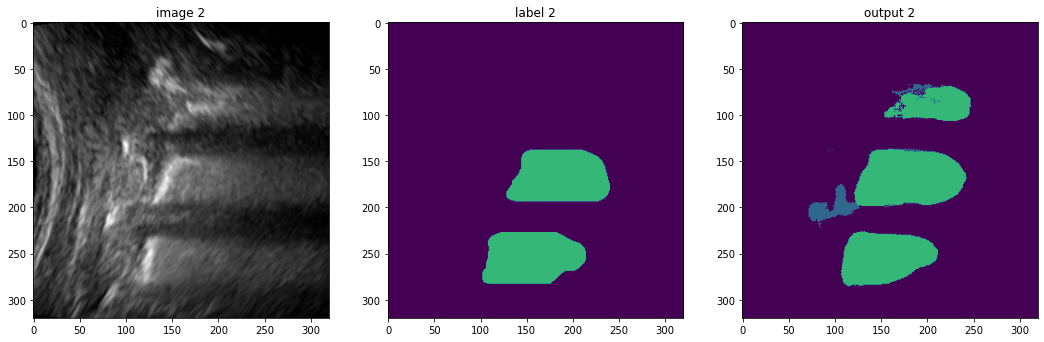

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/034s_iimage_3401832241774_clean.nii.gz


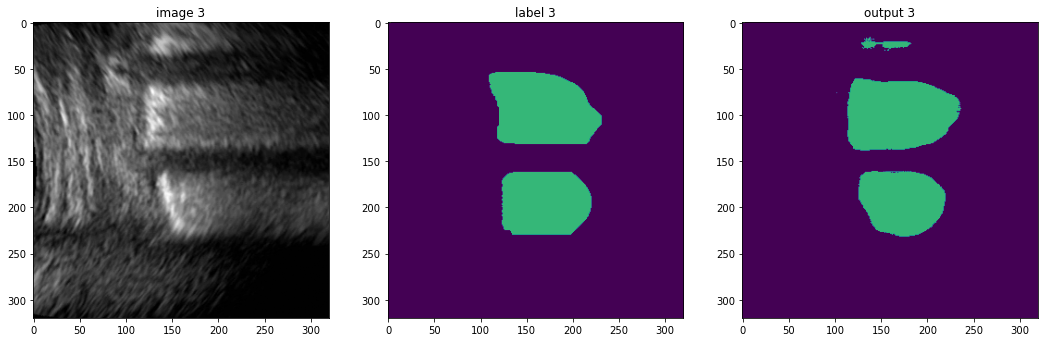

VFOLD = 5 of 15


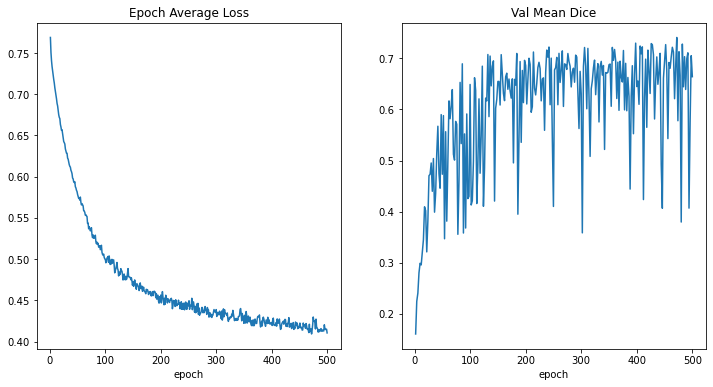

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/048ns_image_1543571117118_clean.nii.gz


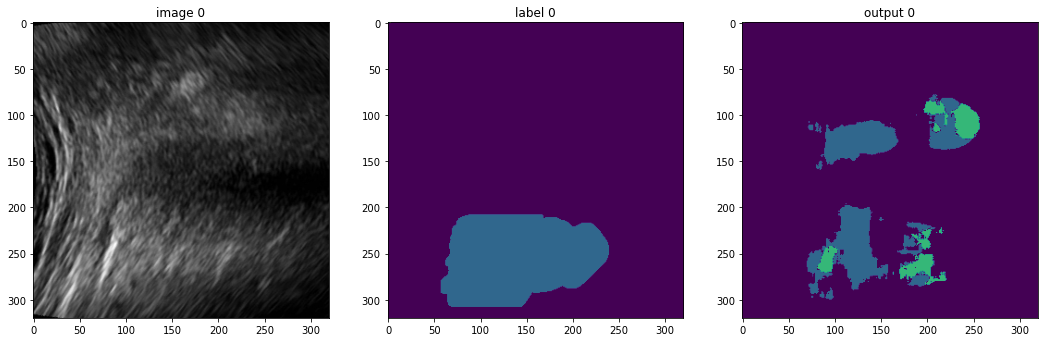

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/048ns_image_1749559540112_clean.nii.gz


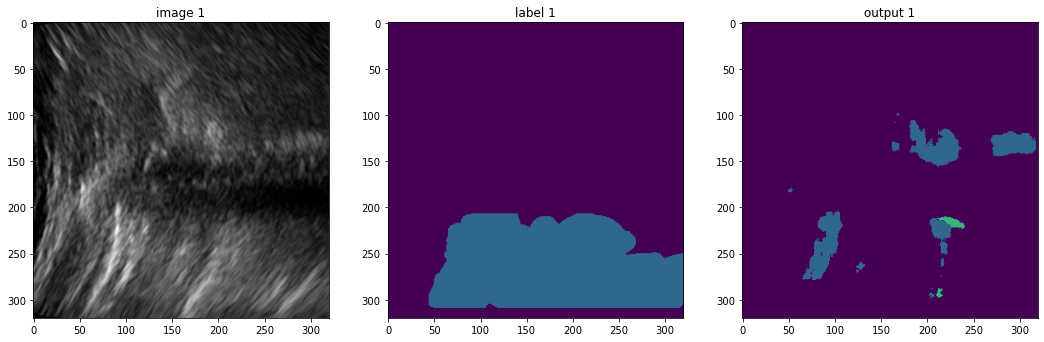

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/037s_iimage_588413346180_CLEAN.nii.gz


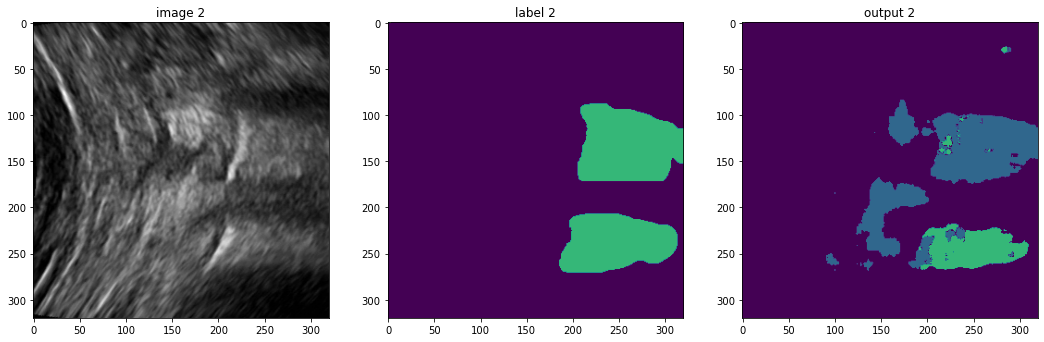

VFOLD = 6 of 15


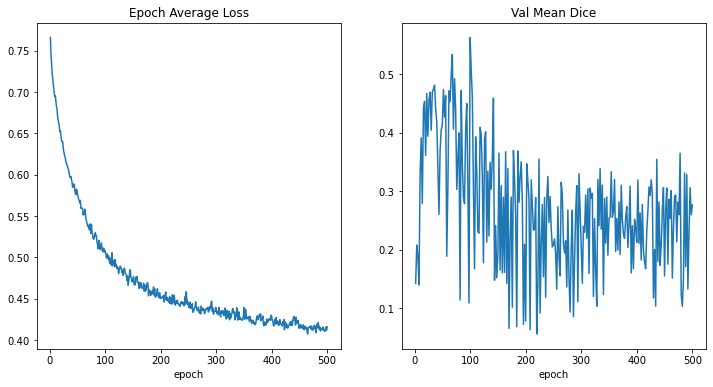

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/055ns_image_27180764486244_CLEAN.nii.gz


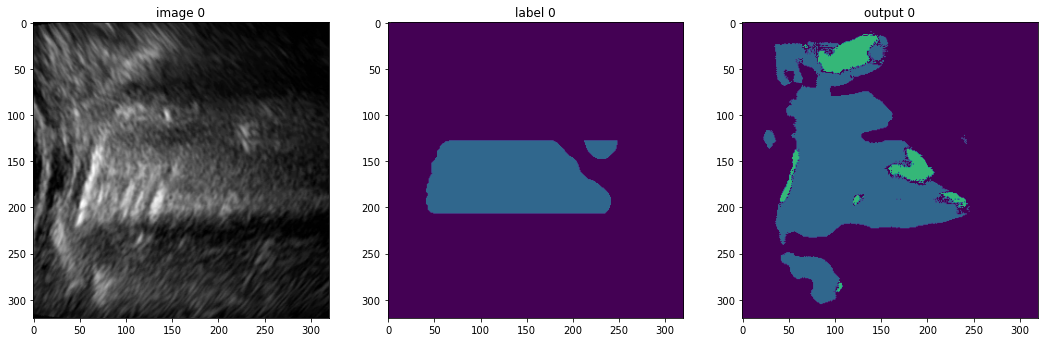

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/055ns_image_27185428518326_CLEAN.nii.gz


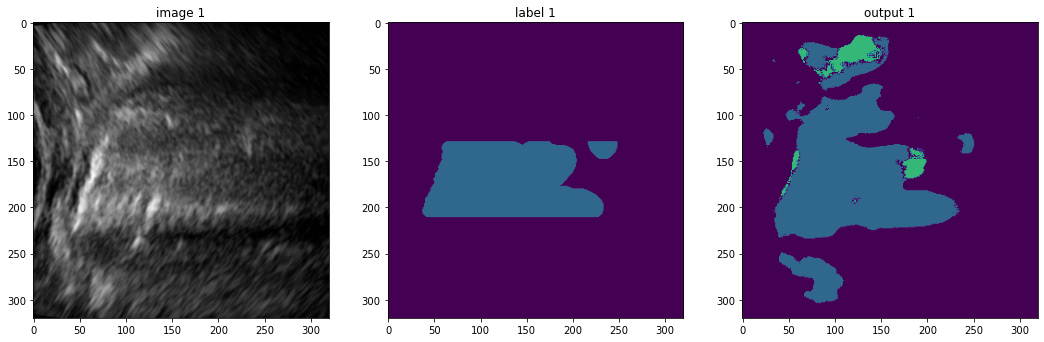

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/043s_iimage_10391571128899_CLEAN.nii.gz


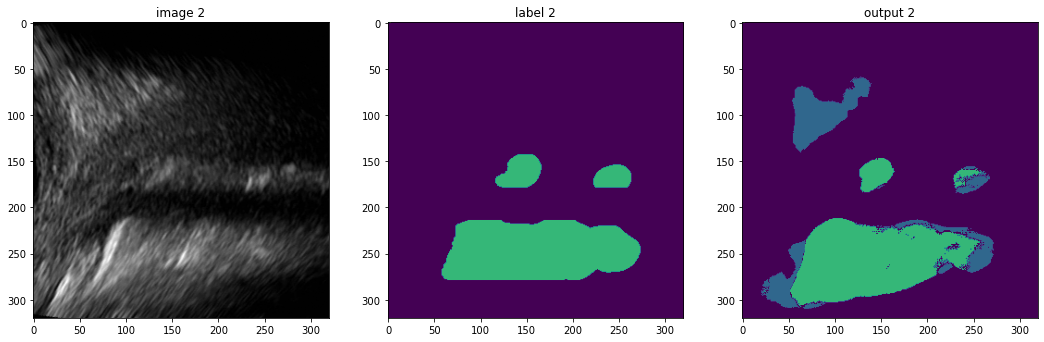

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/043s_iimage_10395655826502_CLEAN.nii.gz


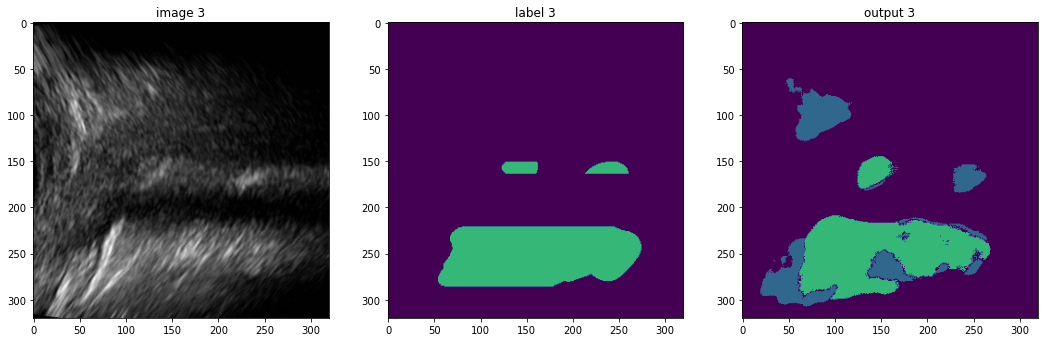

VFOLD = 7 of 15
  File not found: ./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold_loss_7.npy
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/117ns_image_417221672548_CLEAN.nii.gz


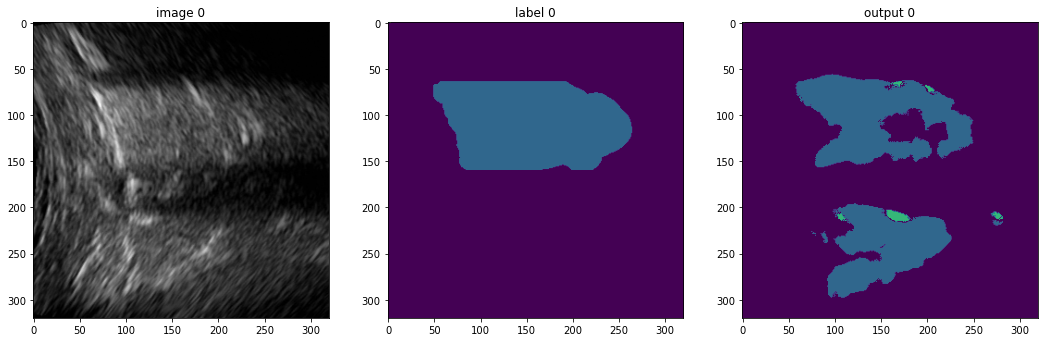

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/117ns_image_426794579576_CLEAN.nii.gz


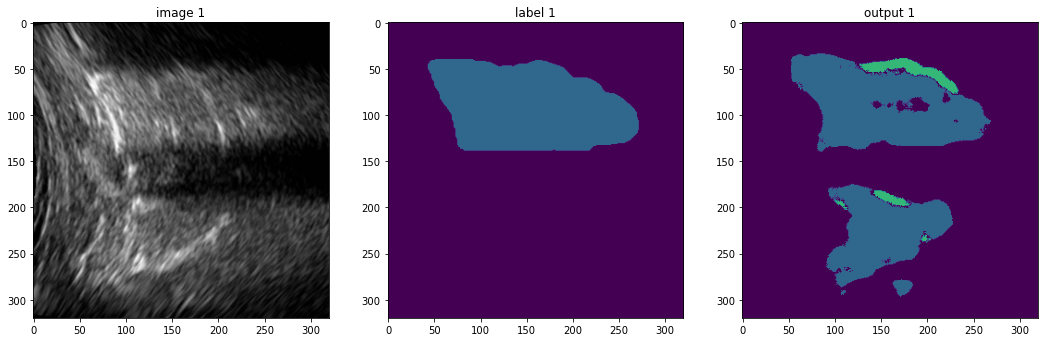

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/065s_iimage_1896534330004_clean.nii.gz


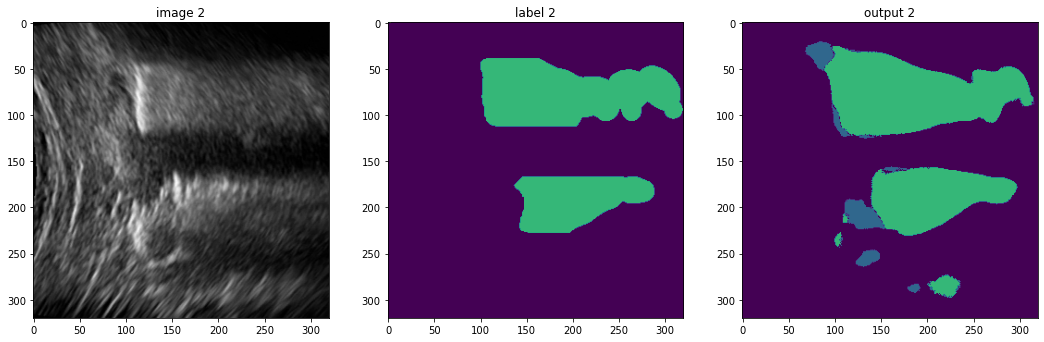

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/065s_iimage_1901852337971_clean.nii.gz


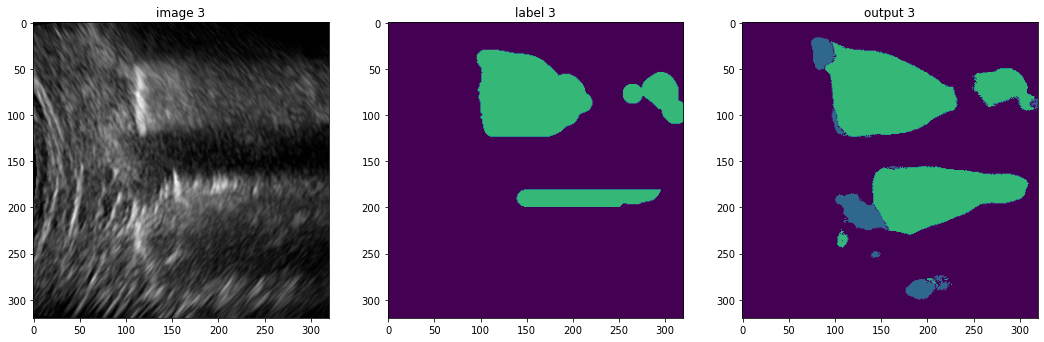

VFOLD = 8 of 15


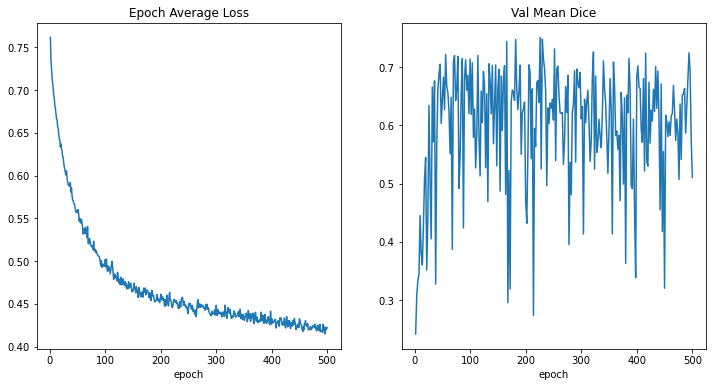

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/135ns_image_2418161753608_clean.nii.gz


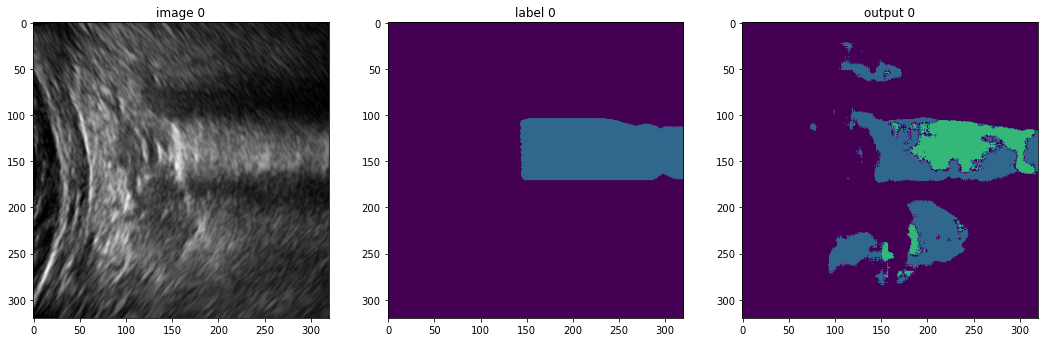

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/135ns_image_2454526567135_CLEAN.nii.gz


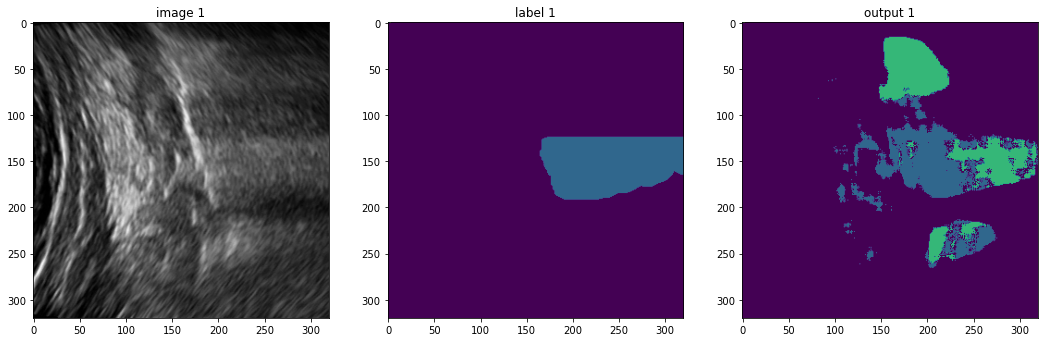

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_2959672151786_clean.nii.gz


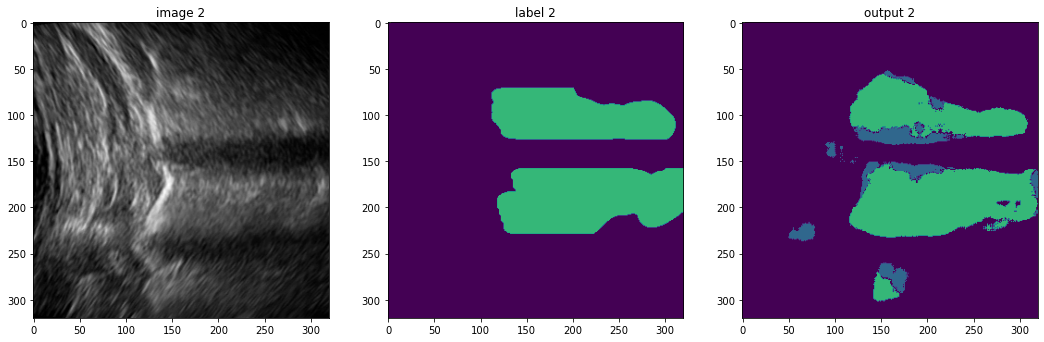

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz


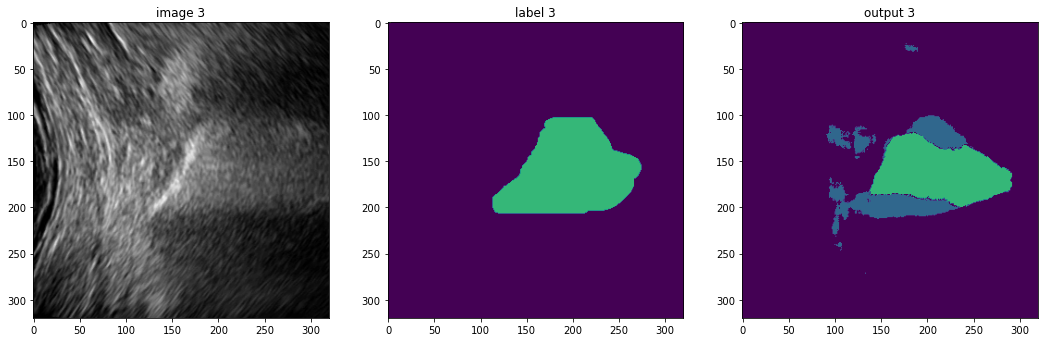

VFOLD = 9 of 15


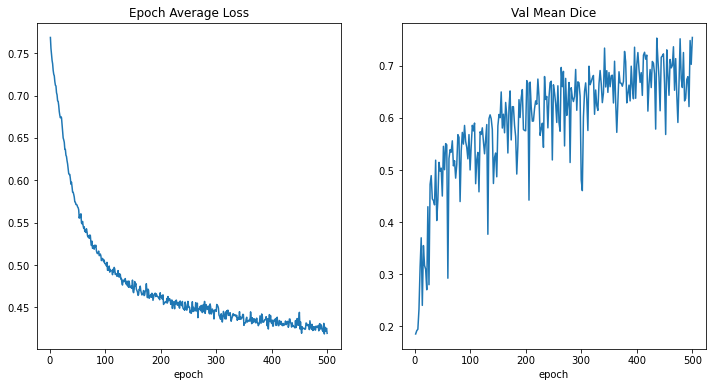

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/193ns_image_634125159704_CLEAN.nii.gz


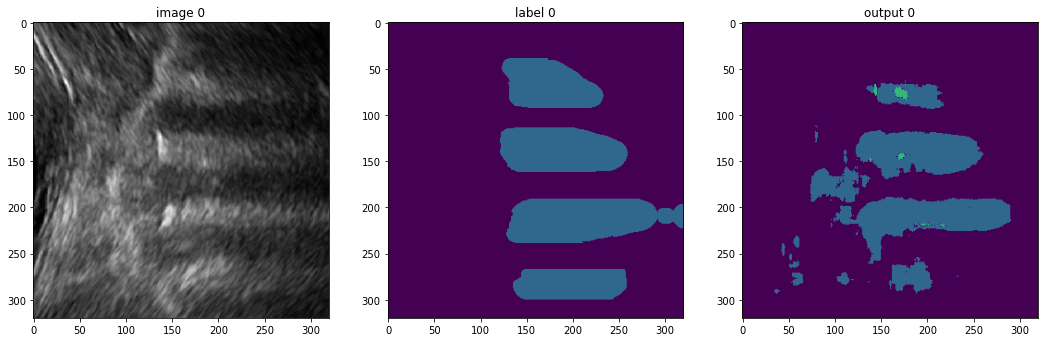

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/193ns_image_642169070951_clean.nii.gz


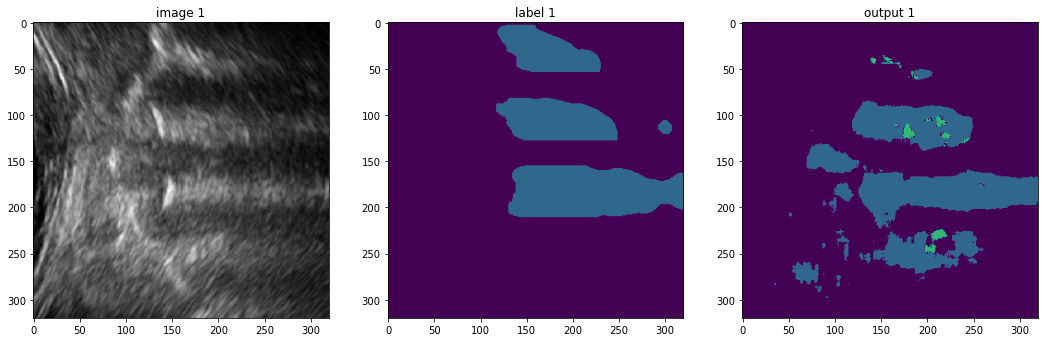

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/206s_iimage_1499268364374_clean.nii.gz


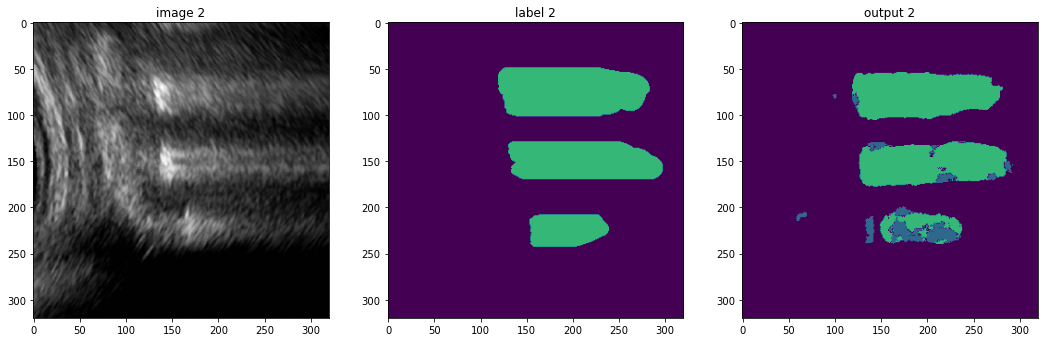

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/206s_iimage_1511338287338_clean.nii.gz


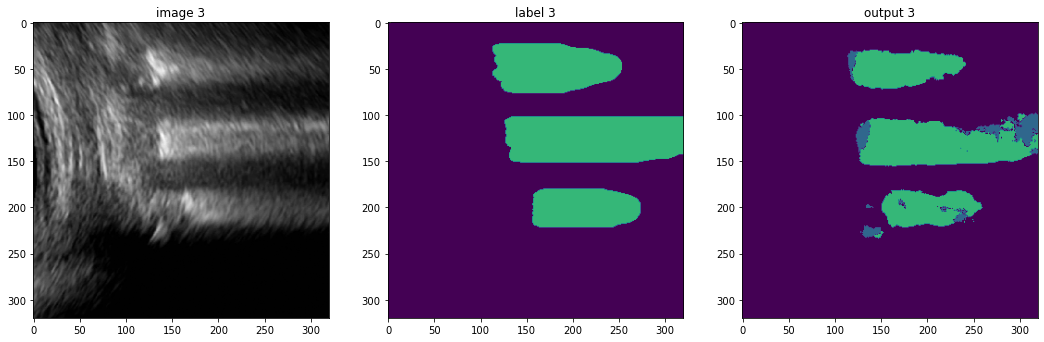

VFOLD = 10 of 15
  File not found: ./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold_loss_10.npy
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/210ns_image_603665940081_clean.nii.gz


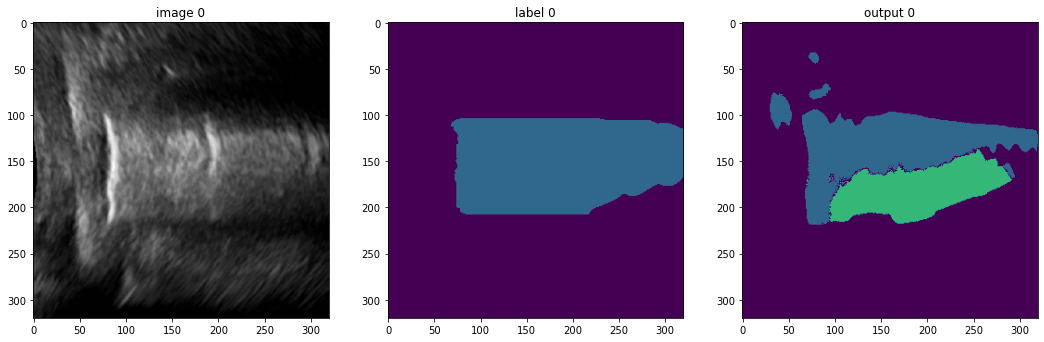

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/210ns_image_614587120545_clean.nii.gz


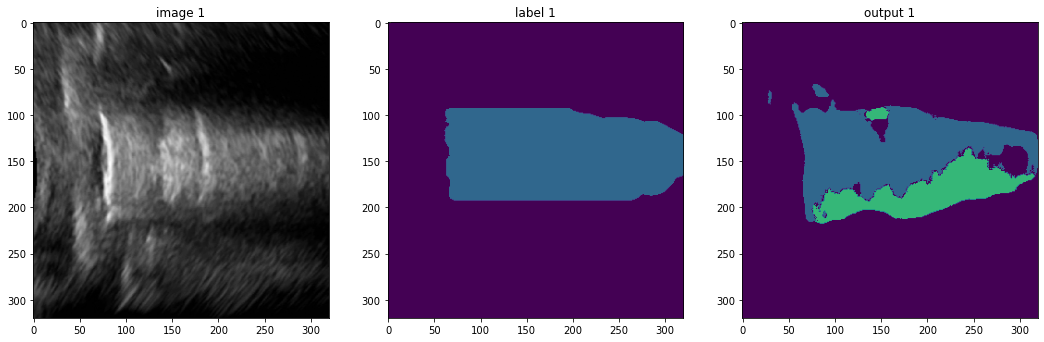

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/208s_iimage_104543812690743_CLEAN.nii.gz


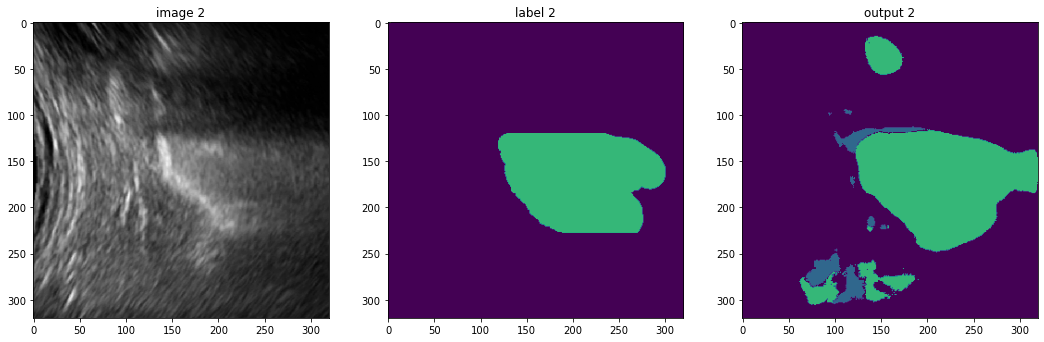

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/208s_iimage_104548309385533_CLEAN.nii.gz


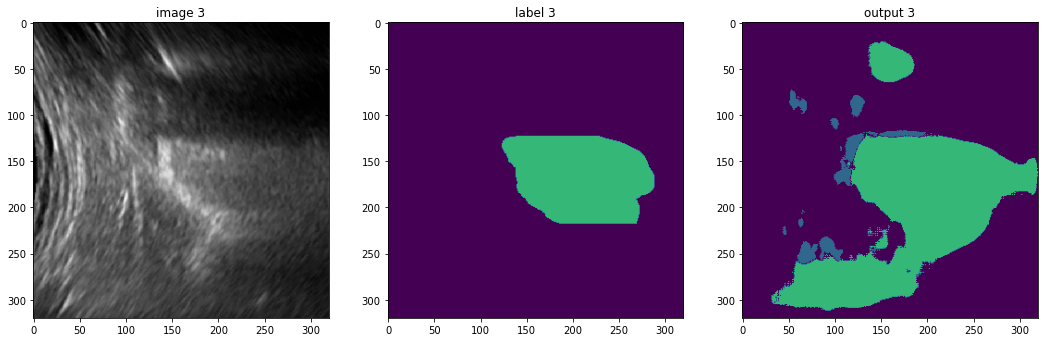

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/208s_iimage_104932526155699_CLEAN.nii.gz


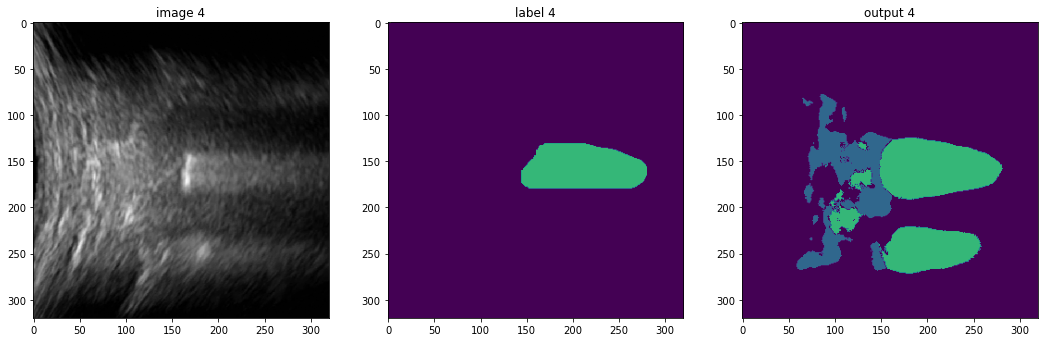

VFOLD = 11 of 15
  File not found: ./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold_loss_11.npy
  File not found: ./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold_11.pth
VFOLD = 12 of 15


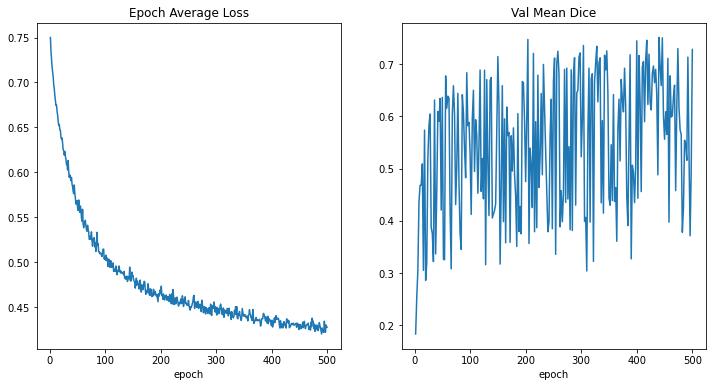

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/218ns_image_6056976176281_CLEAN.nii.gz


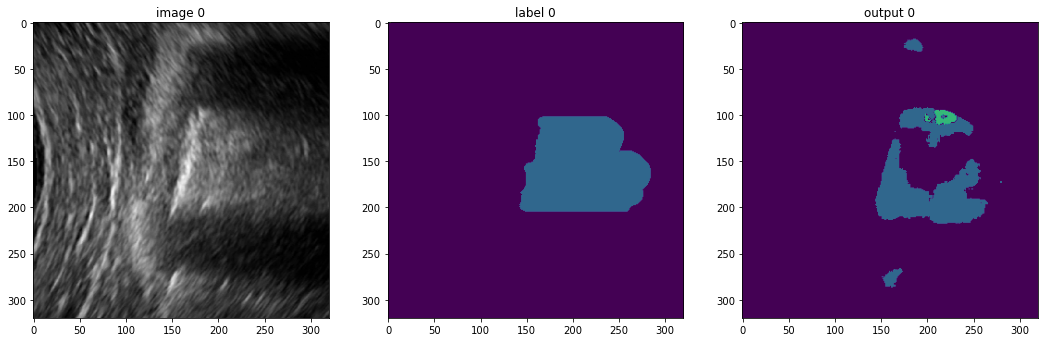

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/218ns_image_6370410622099_CLEAN.nii.gz


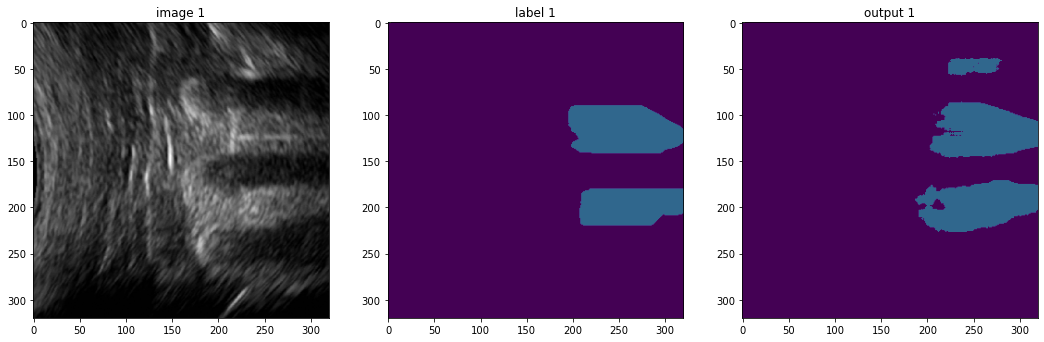

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/212s_iimage_128683942015128_CLEAN.nii.gz


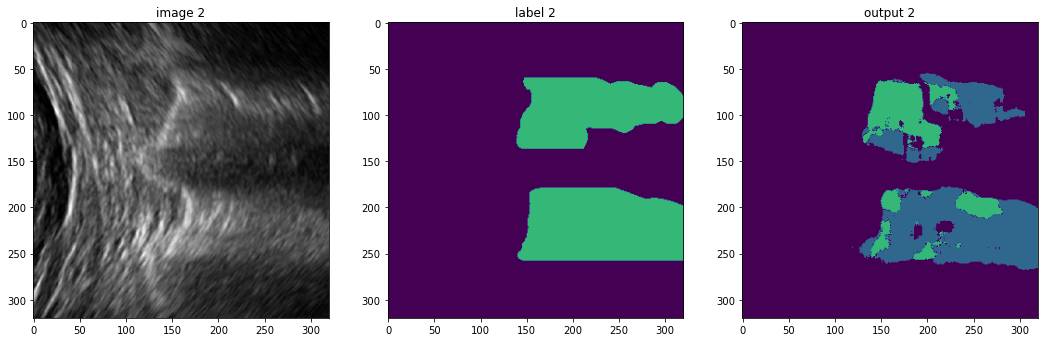

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/212s_iimage_128688523296793_CLEAN.nii.gz


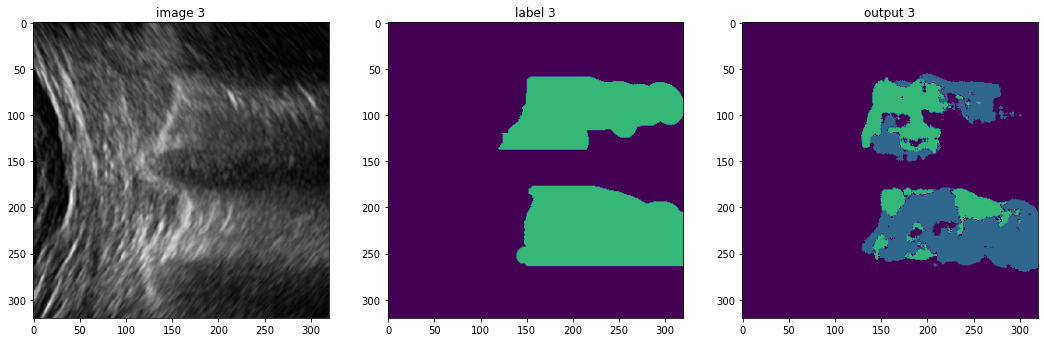

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/212s_iimage_128692595484031_CLEAN.nii.gz


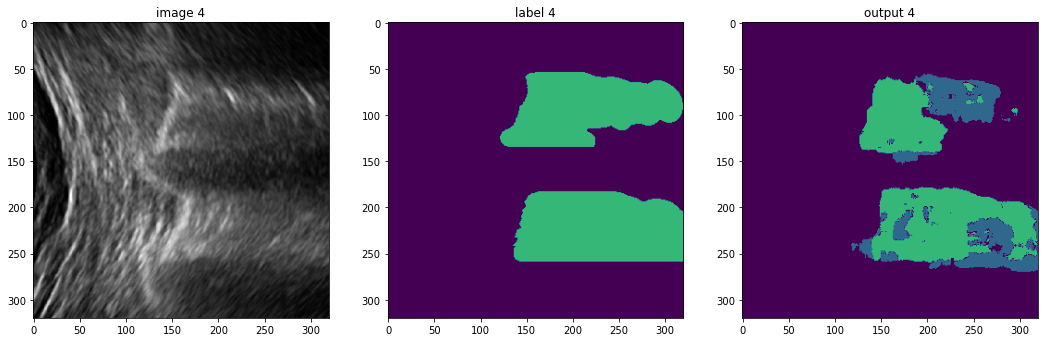

VFOLD = 13 of 15


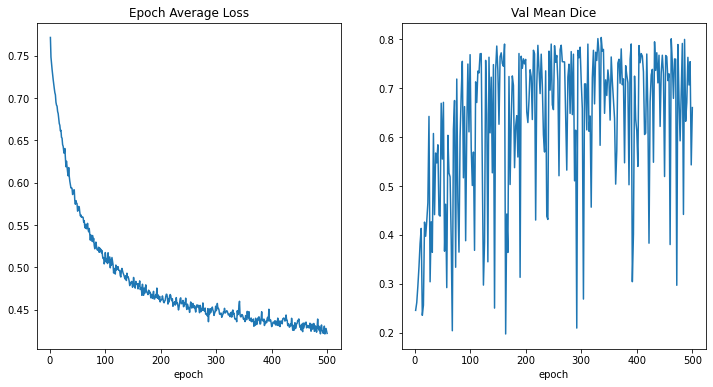

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/219ns_image_1884162273498_clean.nii.gz


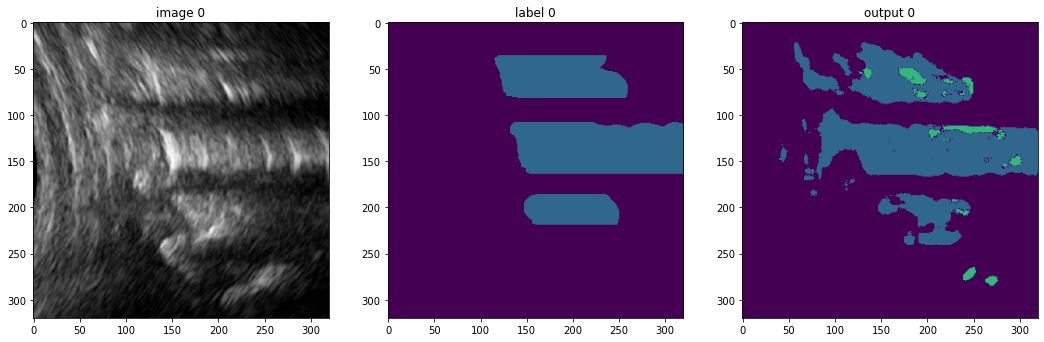

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/219ns_image_1895283541879_clean.nii.gz


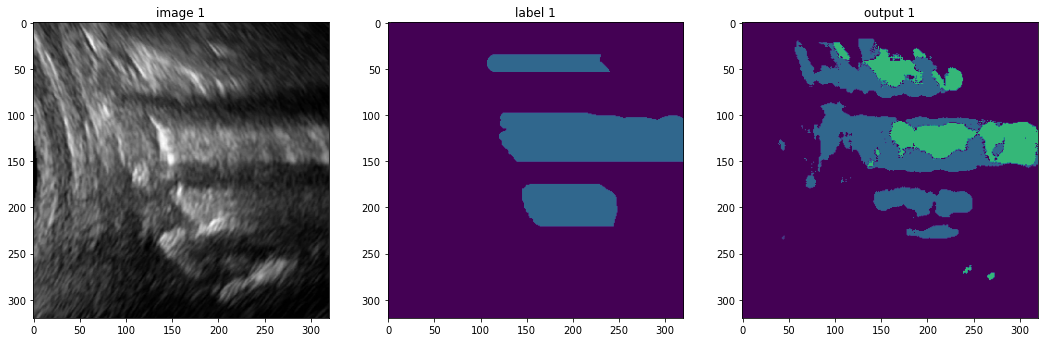

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/224s_iimage_3308406916756_clean.nii.gz


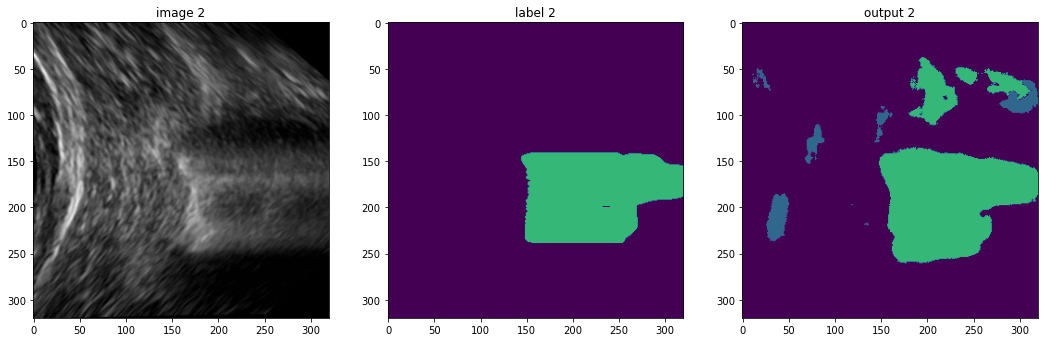

../../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/224s_iimage_3315947589826_clean.nii.gz


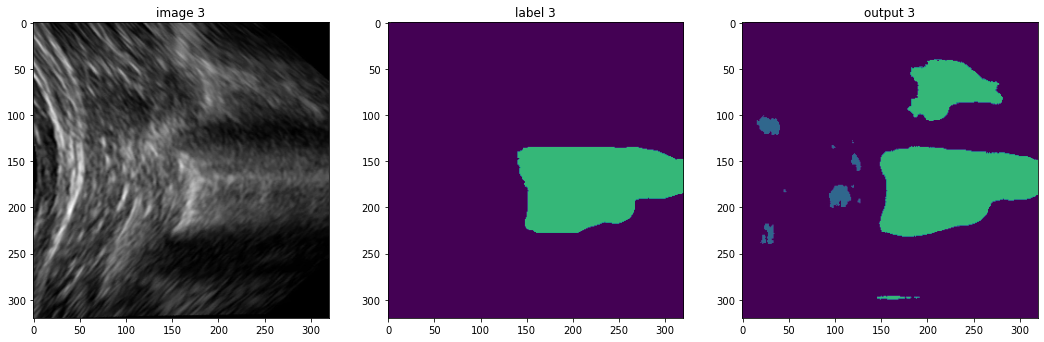

VFOLD = 14 of 15
  File not found: ./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold_loss_14.npy
  File not found: ./results/BAMC_PTX_3DUNet-NS-Extruded.best_model.vfold_14.pth


In [12]:
for i in range(num_folds):
    plot_vfold_training_curves(i, test_loader[i])